**IMPORT THƯ VIỆN**

In [0]:
%tensorflow_version 1.x
from keras.utils import to_categorical
import tensorflow as tf
import sklearn
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import seaborn as sns
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import*
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from keras.applications import VGG16;
from keras.applications.vgg16 import preprocess_input
import tensorflow_hub as tfHub
from tensorflow.keras import layers as tfLayers
from sklearn.metrics import confusion_matrix, classification_report
import itertools

**DOWLOAD DỮ LIỆU TỪ KAGGLE**

In [0]:
!pip install kaggle

In [0]:
! mkdir ~/.kaggle

In [0]:
!cp './kaggle.json' '/root/.kaggle/'

In [0]:
!kaggle datasets download --force -d 'zalando-research/fashionmnist'
!rm '/root/.kaggle/kaggle.json'

 93% 64.0M/68.8M [00:00<00:00, 50.2MB/s]
100% 68.8M/68.8M [00:00<00:00, 83.2MB/s]


In [0]:
!unzip 'fashionmnist.zip' -d 'my_data'

Archive:  fashionmnist.zip
  inflating: my_data/fashion-mnist_test.csv  
  inflating: my_data/fashion-mnist_train.csv  
  inflating: my_data/t10k-images-idx3-ubyte  
  inflating: my_data/t10k-labels-idx1-ubyte  
  inflating: my_data/train-images-idx3-ubyte  
  inflating: my_data/train-labels-idx1-ubyte  


**ĐỌC DỮ LIỆU**

In [0]:
train_dataset = pd.read_csv('./my_data/fashion-mnist_train.csv').values
test_dataset = pd.read_csv('./my_data/fashion-mnist_test.csv').values
train_data = pd.read_csv('./my_data/fashion-mnist_train.csv')
test_data = pd.read_csv('./my_data/fashion-mnist_test.csv')
num_train_examples = len(train_dataset)
num_test_examples = len(test_dataset)


In [0]:
train_df = pd.read_csv('./my_data/fashion-mnist_train.csv',sep=',')
test_df = pd.read_csv('./my_data/fashion-mnist_test.csv', sep = ',')

In [0]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


In [0]:
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,0,0,34,29,7,0,11,24,0,0,3,3,1,0,1,1,0,0,0,0,0,4,0,0,1,0,0,0,0,0,...,242,245,224,245,234,0,3,0,0,0,0,0,0,0,0,0,0,0,0,37,69,94,123,127,138,138,142,145,135,125,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,209,190,181,150,170,193,180,219,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,...,248,238,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,174,233,155,0,65,235,216,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,17,0,0,0,0,0,0,0,0,12,94,68,14,0,0,0,0,0,0,0,0,0,0,0,38,106,94,89,94,68,...,0,0,0,0,0,0,87,12,26,0,0,0,0,0,0,0,46,50,29,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,161,212,138,150,169,164,176,202,255,183,26,0,0,0,0,0,0,0,0,0,0,0,1,0,0,129,221,255,255,215,...,255,255,254,252,255,101,196,254,252,100,0,0,0,0,0,168,232,225,0,41,172,147,148,153,155,146,137,141,143,137,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,204,235,...,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,69,0,2,0,0,0,0,0,0,0,0,0,0


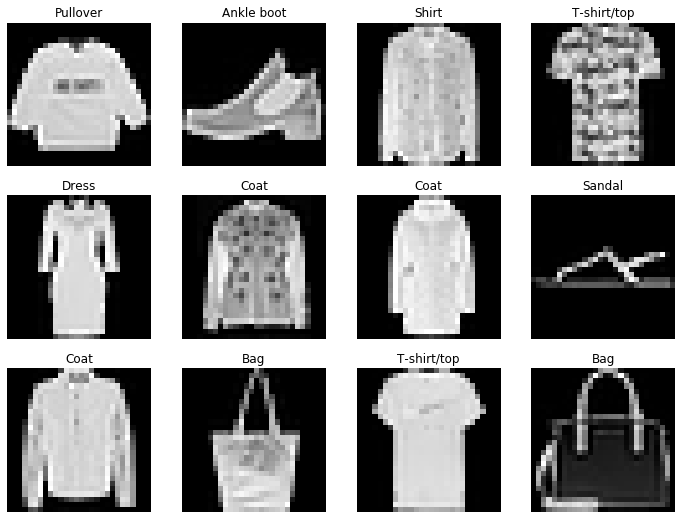

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']
num_classes = len(class_names)

plt.figure(figsize=(12,9))
for i in range(0,12):
    plt.subplot(3,4,i+1)
    image_resized = np.resize(train_data.iloc[i,1:].values,(28,28))
    plt.title(class_names[train_data.iloc[i,0]])
    plt.imshow(image_resized, cmap='gray', interpolation='none')
    plt.axis('off')

Các class sẽ phân bố đều vào 60000 hình ảnh


In [0]:
print('num_train: ',num_train_examples)
print('num_test: ',num_test_examples)
print('num_class: ',num_classes)

num_train:  60000
num_test:  10000
num_class:  10


**PREROCESS DATA**

 Lưu ý rằng chúng ta có các hình ảnh dưới dạng vector 1 chiều mỗi hình chứa 784 pixel.

Trước khi đưa vào model CNN,  phải định hình lại dữ liệu thành ma trận 3 chiều (28x28x1). 

Nếu đây là hình ảnh RGB, sẽ có 3 kênh, nhưng vì MNIST có thang màu xám nên nó chỉ sử dụng một kênh.

Giá trị của mỗi pixel trong dữ liệu ảnh là một số nguyên trong phạm vi [0,255]. Để mô hình hoạt động chính xác, các giá trị này cần được chuẩn hóa thành phạm vi [0,1]. 

x = (x - min) / (max - min) ;  min=0 and max=255

In [0]:
train_dataset_x = train_dataset[:,1:] / 255
train_dataset_x = train_dataset_x.reshape((num_train_examples, 28, 28, 1))
train_dataset_y = train_dataset[:,0]


test_dataset_x = test_dataset[:,1:] / 255
test_dataset_x = test_dataset_x.reshape((num_test_examples, 28, 28, 1))
test_dataset_y = test_dataset[:,0]


In [0]:
train_dataset.shape,test_dataset.shape

((60000, 785), (10000, 785))

Các nhãn được đưa ra dưới dạng số nguyên trong khoảng 0-9. Chúng ta cần one-hot encode 

ví dụ:  8 được biểu diễn thành [0, 0, 0, 0, 0, 0, 0, 0, 1, 0].



In [0]:
train_Y_one_hot = to_categorical(train_dataset_y)
test_Y_one_hot = to_categorical(test_dataset_y)

In [0]:
train_Y_one_hot.shape,test_Y_one_hot.shape

((60000, 10), (10000, 10))

Chia tập train và validation 

In [0]:
X_train, X_val, y_train, y_val = train_test_split(train_dataset_x, train_Y_one_hot, test_size=0.2, random_state=13)

In [0]:
X_train.shape,y_train.shape

((48000, 28, 28, 1), (48000, 10))

**Hàm vẽ**

In [0]:
def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace
    
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['acc']
    val_acc = hist['val_acc']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    
    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
   
    fig = tools.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])

    
    iplot(fig, filename='accuracy-loss')



**BUILD CNN MODEL**

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)

])


In [0]:
model.summary();

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
flatten_6 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)              

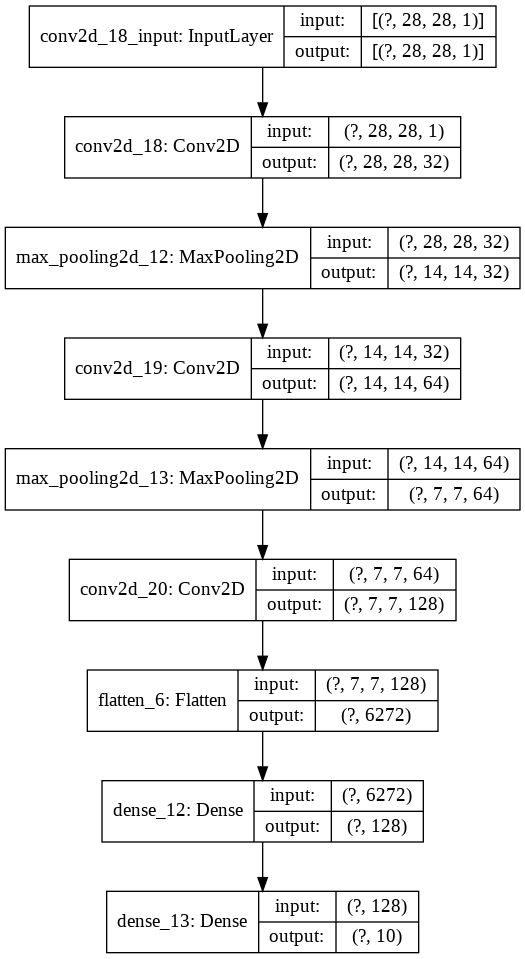

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model , 'classyfier.png' , show_shapes=True)

Loss function : An algorithm for measuring how far the model's outputs are from the desired output. The goal of training is this measures loss.

Optimizer :An algorithm for adjusting the inner parameters of the model in order to minimize loss.

Metrics :Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

In [0]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

**train model**

In [0]:

history = model.fit(X_train, y_train,
          batch_size=256,
          epochs=30,
          verbose=1,
          validation_data=(X_val, y_val))


Train on 48000 samples, validate on 12000 samples
Epoch 1/30
48000/48000 [==============================] - 77s 2ms/sample - loss: 0.6061 - acc: 0.7784 - val_loss: 0.3992 - val_acc: 0.8537
Epoch 2/30
48000/48000 [==============================] - 77s 2ms/sample - loss: 0.3454 - acc: 0.8764 - val_loss: 0.3328 - val_acc: 0.8754
Epoch 3/30
48000/48000 [==============================] - 77s 2ms/sample - loss: 0.2934 - acc: 0.8932 - val_loss: 0.3278 - val_acc: 0.8813
Epoch 4/30
48000/48000 [==============================] - 77s 2ms/sample - loss: 0.2600 - acc: 0.9063 - val_loss: 0.2630 - val_acc: 0.9034
Epoch 5/30
48000/48000 [==============================] - 77s 2ms/sample - loss: 0.2363 - acc: 0.9144 - val_loss: 0.2813 - val_acc: 0.9001
Epoch 6/30
48000/48000 [==============================] - 76s 2ms/sample - loss: 0.2132 - acc: 0.9228 - val_loss: 0.2611 - val_acc: 0.9014
Epoch 7/30
48000/48000 [==============================] - 76s 2ms/sample - loss: 0.2002 - acc: 0.9267 - val_loss: 0.

In [0]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


In [0]:
plot_accuracy_and_loss(history)

/usr/local/lib/python3.6/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



predict trên test

In [0]:
score = model.evaluate(test_dataset_x, test_Y_one_hot)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


10000/10000 [==============================] - 5s 535us/sample - loss: 0.4231 - acc: 0.9253
Test loss: 0.4231032437230111
Test accuracy: 0.9253


**=> overfitting**

**thêm DropOut vào mô hình**

In [0]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.25), 
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.25), 
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.4), 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)

])

In [0]:
model_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model_2.summary();

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 7, 7, 128)        

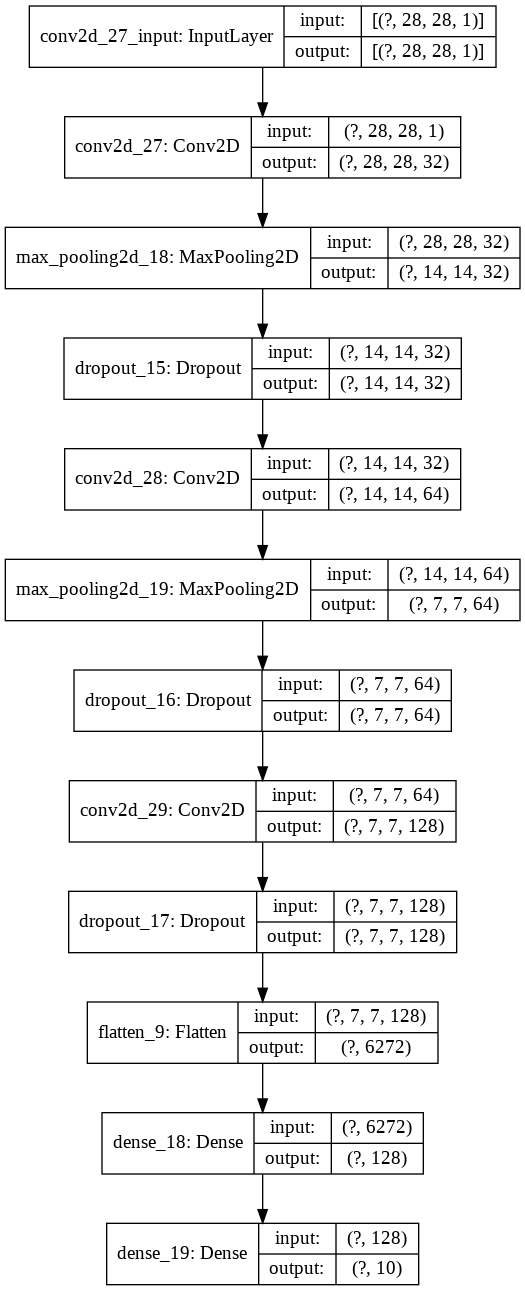

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model_2 , 'classyfier.png' , show_shapes=True)

**Data Augmentation**

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range = 8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        shear_range = 0.3,# shear angle in counter-clockwise direction in degrees  
        width_shift_range=0.08,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.08,  # randomly shift images vertically (fraction of total height)
        vertical_flip=True)  # randomly flip images
batches = datagen.flow(X_train, y_train, batch_size=256)


In [0]:
print(len(batches)

188 47


In [0]:
print(len(batches))

188


In [0]:


history3 = model_2.fit_generator(batches, steps_per_epoch=48000//256, epochs=30,
                    validation_data=(X_val, y_val), verbose=1)


Epoch 1/30
187/187 [==============================] - 95s 509ms/step - loss: 0.9159 - acc: 0.6547 - val_loss: 0.5685 - val_acc: 0.7874
Epoch 2/30
187/187 [==============================] - 94s 503ms/step - loss: 0.6266 - acc: 0.7622 - val_loss: 0.5177 - val_acc: 0.8049
Epoch 3/30
187/187 [==============================] - 93s 499ms/step - loss: 0.5565 - acc: 0.7892 - val_loss: 0.4667 - val_acc: 0.8282
Epoch 4/30
187/187 [==============================] - 93s 500ms/step - loss: 0.5175 - acc: 0.8057 - val_loss: 0.4295 - val_acc: 0.8499
Epoch 5/30
187/187 [==============================] - 93s 499ms/step - loss: 0.4896 - acc: 0.8165 - val_loss: 0.4035 - val_acc: 0.8528
Epoch 6/30
187/187 [==============================] - 93s 498ms/step - loss: 0.4608 - acc: 0.8281 - val_loss: 0.3598 - val_acc: 0.8693
Epoch 7/30
187/187 [==============================] - 93s 497ms/step - loss: 0.4474 - acc: 0.8320 - val_loss: 0.3637 - val_acc: 0.8685
Epoch 8/30
187/187 [==============================] - 9

In [0]:
plot_accuracy_and_loss(history3)

/usr/local/lib/python3.6/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



**ĐÁNH GIÁ**

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

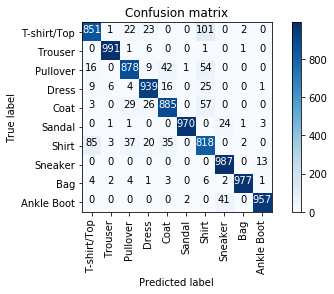

In [0]:

x_test=test_dataset_x
y_test=test_Y_one_hot
# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, 
            classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'])

**Classification Report**

In [0]:
predicted_classes = model_2.predict_classes(x_test)
# get the indices to be plotted
y_true = test_dataset_y
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

In [0]:
print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

Correct predicted classes: 9151
Incorrect predicted classes: 849


In [0]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(10)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.90      0.84      0.87      1000
     Class 1       0.98      0.99      0.99      1000
     Class 2       0.92      0.83      0.87      1000
     Class 3       0.88      0.96      0.92      1000
     Class 4       0.89      0.83      0.86      1000
     Class 5       0.99      0.97      0.98      1000
     Class 6       0.71      0.79      0.75      1000
     Class 7       0.93      0.98      0.96      1000
     Class 8       0.98      0.99      0.99      1000
     Class 9       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



**đánh giá trên tập test**

In [0]:
score = model_2.evaluate(test_dataset_x, test_Y_one_hot)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 6s 565us/sample - loss: 0.2373 - acc: 0.9151
Test loss: 0.2372579971909523
Test accuracy: 0.9151


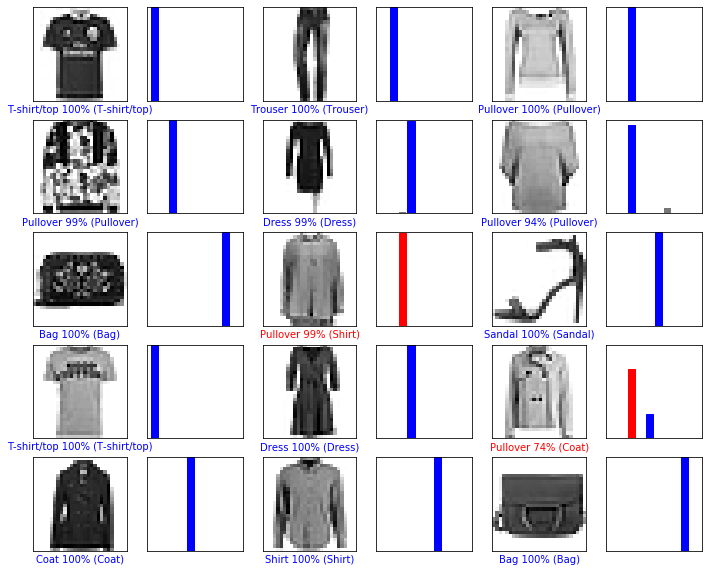

In [0]:
predictions = model.predict(x_test)
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_dataset_y, test_dataset_x)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_dataset_y)